# How to run this notebook (VERY IMPORTANT)

## The NumPy issue
- Please note that we use NumPy library within this notebook. 
    - An issue we found was that NumPy uses multithreading by default, and parallelizing a python function that uses NumPy via processes may result in each process creating a huge number of threads, each competing for CPU resources.
    - Hence we want to prevent each process from spawning multiple threads by default through NumPy.
    - Note NumPy isn't written in Python, and is actually written in C.
    - We need to change numerous thread settings within these C programs, and also within the NumPy program by changing environment variables for these libraries.
    - We can provide these environment variables through passing in command line arguments.
    - Hence please create the below bash script to run this notebook.
    - Run the script through "./<name_of_script>" in terminal
- If the fix is implemented correctly, you should the the python process's CPU usage being maximized at 100% in the activity monitor(in Mac).
- If you add more processes through our implementation, each process's CPU usage will be maximized at 100%.

### Bash Script
```
#!/bin/bash

#Activate your virtual environment
source <location of virtual_env>/bin/activate

# Launch VSCode with specific environment variables.
# If you don't open notebooks via vscode and wish to do it through jupyter notebook instead, comment the line below and uncomment the line 2 lines below it

OMP_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 MKL_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 VECLIB_MAXIMUM_THREADS=1 BLIS_NUM_THREADS=1 code .
# OMP_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 MKL_NUM_THREADS=1 NUMEXPR_NUM_THREADS=1 VECLIB_MAXIMUM_THREADS=1 BLIS_NUM_THREADS=1 jupyter notebook .
```

## Virtual Environment
- The virtual environment should have the packages seen below in the imports.
    - SGD_with_k_samples is an internal python file for this notebook.

# Importing Libraries

In [19]:
import numpy as np
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt
import pandas as pd
import SGD_with_k_samples
import random

# Preliminary work

- One of the datasets from the paper was chosen (same as considered for other methods)
- We have chosen only one feature, "V" to use for prediction.
- We have standardised "V" and the target variable "AT" 
- We have chosen a dataset which requires polynomial linear regression
- As a result the line we're trying to fit is $y=\beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \epsilon$
- As we need to transform (N * 1) matrix $X$ to (N * 4) matrix as a result where ith row is $\begin{bmatrix} 1 & x_i & x_i^2 & x_i^3 \end{bmatrix}$, the function $polynomial\_basis\_function\_transformation$ was created.
- We have also set the random seed to be 40

In [21]:
# Loading the dataset
dataframe = pd.read_excel('dataset1/dataset1.xlsx')

X = dataframe['V'].sort_values()
X = (X - X.mean()) / X.std()
y = dataframe['AT'][X.index].values
y = (y - y.mean()) / y.std()

X = np.reshape(X.values, (-1, 1))

def polynomial_basis_function_transformation(X, h):
    """
    Converts an (N * 1) matrix into a (N * h) matrix where h is the number of basis functions ()
    The degree of the polynomial is (h-1)
    """
    powers = np.arange(h)
    X_poly = np.power(X, powers)
    return X_poly

In [15]:
random.seed(40)

The next two cells contain the same code that is in the the python file we have imported in the beginning of this notebook and hence do not need to be run. 

In [23]:
def compute_gradient(args):
    """
    Computes the gradient of the MSE loss for the mini-batch of data in the polynomial regression model.
    Transforms input feature into polynomial feature.
    Calculares prediction error.
    Computes average gradient across mini-batch used to update model parameters
    """
    X_batch, y_batch, alpha = args
    X_poly = polynomial_basis_function_transformation(X_batch, 4)
    m = len(y_batch)  # Mini-batch size
    predictions = X_poly.dot(alpha)  # Linear regression predictions
    errors = predictions - y_batch
    gradient = (1 / m) * X_poly.T.dot(errors)
    return gradient

def parallel_sgd_with_k_samples(X, y, alpha, learning_rate, epochs, num_threads, k):
    """
    Implements parallelized stochastic gradient descent with k samples, potentially speeding up the SGD process.
    Inititalises pool of worker processes for parallel computing.
    Data is shuffled and split into mini batches for each epoch while gradient is computed in parallel using worker pool.
    Gradients are averaged, model parameters updated and MSE and time taken are recorded.
    """
    mse_history = []
    time_taken = []
    pool = Pool(processes=num_threads)  # Create a pool of workers
    start_time = time.time()

    for epoch in range(epochs):
        
        
        # Shuffle data
        indices = np.random.choice(len(y), size=i(k*num_threads), replace=True)
        random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        X_poly = polynomial_basis_function_transformation(X_shuffled, 4)

        # Split data into mini-batches
        mini_batches = [
            (X_shuffled[i:i+k], y_shuffled[i:i+k], alpha)
            for i in range(0, (k*num_threads), k)
        ]

        # Compute gradients in parallel
        gradients = pool.map(compute_gradient, mini_batches)

        # Average the gradients across all threads
        avg_gradient = np.mean(gradients, axis=0)

        # Update parameters (alpha)
        alpha -= learning_rate * avg_gradient

        # Calculate MSE
        mse = np.mean((X_poly.dot(alpha) - y) ** 2)  # MSE using the updated parameters
        mse_history.append(mse)

        # Calculate time taken for the epoch
        end_time = time.time()
        elapsed_time = end_time - start_time
        time_taken.append(elapsed_time)



    pool.close()
    pool.join()
    
    return mse_history, time_taken


In [25]:
def estimation(n, X, y, learning_rate, epochs, num_threads, k):
    """
    Performs multiple runs of parallel SGD algorithm and then averages the results. Reduces impact of random initialisation.
    Runs the above function 'parallel_sgd_with_k_samples' n times with a new random initialisation of alpha each time.
    Each run records MSE history and time taken.
    Computes average MSE and average time taken on all runs. 
    """
    df_mse_rows = []
    df_time_rows = []
    for _ in range(n):
        alpha = np.random.rand(4)
        mse, time = parallel_sgd_with_k_samples(X, y, alpha, learning_rate, epochs, num_threads, k)  # Call the function
        df_mse_rows.append(mse)  
        df_time_rows.append(time)
    df_mse = pd.DataFrame(df_mse_rows)
    df_time = pd.DataFrame(df_time_rows)
    df_mse_avg = df_mse.mean(axis=0)
    df_time_avg = df_time.mean(axis=0)
    return df_mse_avg, df_time_avg




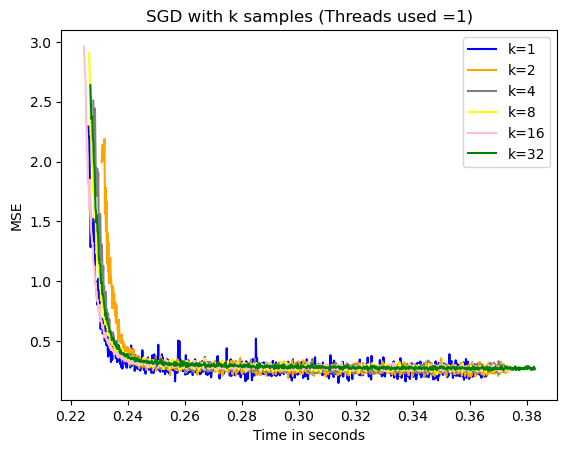

In [53]:
# Hyperparameters
learning_rate = 0.01
epochs = 1000
num_threads = 1  # Number of threads


if __name__ == "__main__":
    """
    Calls function 'estimation' with different batch sizes: k = 1, 2, 4, 8, 16, 32
    Comparison of SGD performance with varying batch sizes and how they affect speed of convergance and final MSE.
    """
    mse_1,time_1 = SGD_with_k_samples.estimation(100, X, y, learning_rate, epochs, num_threads, 1)
    mse_2,time_2 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 2)
    mse_4,time_4 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 4)
    mse_8,time_8 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 8)
    mse_16,time_16 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 16)
    mse_32,time_32 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 32)
    
    plt.xlabel('Time in seconds')
    plt.ylabel('MSE')
    plt.title('SGD with k samples (Threads used =1)')
    plt.plot(time_1,mse_1, label = "k=1", color="blue", linestyle="-")
    plt.plot(time_2,mse_2, label = "k=2", color="orange", linestyle="-")
    plt.plot(time_4,mse_4, label = "k=4", color="grey", linestyle="-")
    plt.plot(time_8,mse_8, label = "k=8", color="yellow", linestyle="-")
    plt.plot(time_16,mse_16, label = "k=16", color="pink", linestyle="-")
    plt.plot(time_32,mse_32, label = "k=32", color="green", linestyle="-")
    plt.legend()

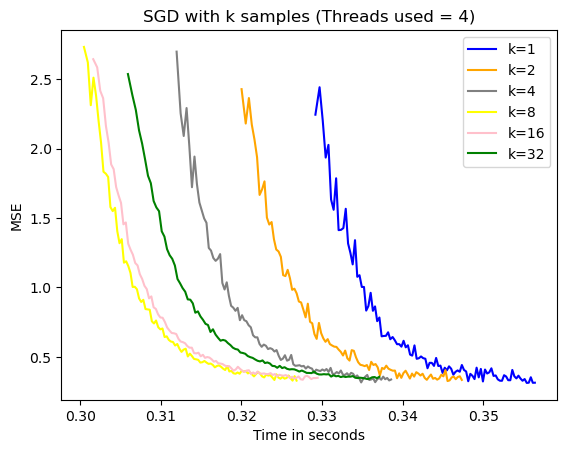

In [55]:
# Hyperparameters
learning_rate = 0.01
epochs = 100
num_threads = 4  # Number of threads

"""
Same plot as above using 4 threads instead of a single thread and 100 epochs insteads of 1000. 
Shows impact of multi-threading on SGD convergence and efficiency of the algorithm.
"""

if __name__ == "__main__":
    mse_1,time_1 = SGD_with_k_samples.estimation(100, X, y, learning_rate, epochs, num_threads, 1)
    mse_2,time_2 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 2)
    mse_4,time_4 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 4)
    mse_8,time_8 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 8)
    mse_16,time_16 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 16)
    mse_32,time_32 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 32)
    
    plt.xlabel('Time in seconds')
    plt.ylabel('MSE')
    plt.title('SGD with k samples (Threads used = 4)')
    plt.plot(time_1,mse_1, label = "k=1", color="blue", linestyle="-")
    plt.plot(time_2,mse_2, label = "k=2", color="orange", linestyle="-")
    plt.plot(time_4,mse_4, label = "k=4", color="grey", linestyle="-")
    plt.plot(time_8,mse_8, label = "k=8", color="yellow", linestyle="-")
    plt.plot(time_16,mse_16, label = "k=16", color="pink", linestyle="-")
    plt.plot(time_32,mse_32, label = "k=32", color="green", linestyle="-")
    plt.legend()

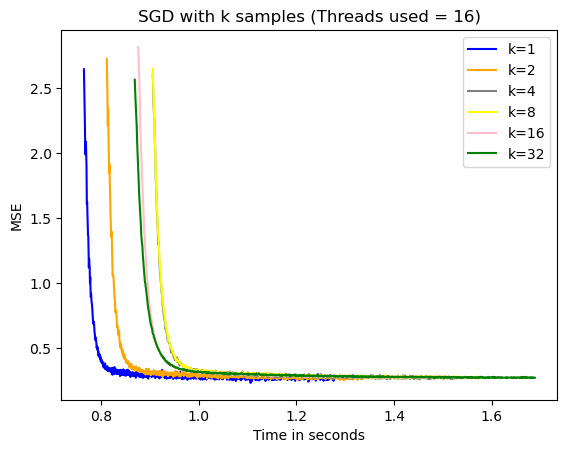

In [54]:
# Hyperparameters
learning_rate = 0.01
epochs = 1000
num_threads = 16  # Number of threads

"""
Same plot as above using 16 threads and set to 1000 epochs. 
With the above plots, we can now analyze how additional parallelisation affects SGD algorithm performance and efficiency,
Helps understand scalability of SGD algorithm in terms of number of threads used.
"""

if __name__ == "__main__":
    mse_1,time_1 = SGD_with_k_samples.estimation(100, X, y, learning_rate, epochs, num_threads, 1)
    mse_2,time_2 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 2)
    mse_4,time_4 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 4)
    mse_8,time_8 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 8)
    mse_16,time_16 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 16)
    mse_32,time_32 = SGD_with_k_samples.estimation(100,X, y, learning_rate, epochs, num_threads, 32)

    plt.xlabel('Time in seconds')
    plt.ylabel('MSE')
    plt.title('SGD with k samples (Threads used = 16)')
    plt.plot(time_1,mse_1, label = "k=1", color="blue", linestyle="-")
    plt.plot(time_2,mse_2, label = "k=2", color="orange", linestyle="-")
    plt.plot(time_4,mse_4, label = "k=4", color="grey", linestyle="-")
    plt.plot(time_8,mse_8, label = "k=8", color="yellow", linestyle="-")
    plt.plot(time_16,mse_16, label = "k=16", color="pink", linestyle="-")
    plt.plot(time_32,mse_32, label = "k=32", color="green", linestyle="-")
    plt.legend()

#### Results

MSE decreases at around the same rate regardless of the value of k when number of threads is 1. Curves are smoother as number of k samples increase as more it takes more time to compute gradient for 32 samples than 1. When number of threads is increased to 4, we can see the MSE curve has high variance. On running this code multiple times, we see that while arellelisation slows down convergence, balue of k does not make much difference as each time, the MSE converhes fastest for a different k.

When we use 16 threads, we see that the MSE converges fastest when computed for 1 sample. Adding parallelization again slows down convergence of the MSE by longer than when we used 4 threads. As threads increase, time spent on communication and syncronisation for averaging the gradient also increases. This is known as communication overhead. In cases like ours, parellisation may not be beneficial and lead to slower convergence.

We must experimemt further with the choice of k, as this experiment has yielded no results in regards to this.